# Setup

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [20]:
os.chdir(root+ "/functions")
import modelling

In [21]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 02 Overfit

In this notebook I am loading the train data and training it for many epochs. want to see whether I can overfit it to perfect (1.0) F1 Scores. That would mean that the model can perform the basic task that I am after. As a model I am using a basic mobilenet because it is small and retrained it for my purposes.

In [22]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 477 files belonging to 3 classes.
Using 382 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 477 files belonging to 3 classes.
Using 95 files for validation.


In [35]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_test,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=False,
)

Found 117 files belonging to 3 classes.


In [36]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
mobileNet = MobileNet(weights='imagenet', include_top=False)
model = modelling.recompile_model(mobileNet, 'rmsprop', 'categorical_crossentropy')

In [26]:
callbacks = EarlyStopping(monitor='loss', mode = "min", patience=5)

In [27]:
epochs=35
history = model.fit(
  train_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/35
12/12 [==============================] - 19s 1s/step - loss: 3.9172 - accuracy: 0.3953
Epoch 2/35
12/12 [==============================] - 15s 1s/step - loss: 1.2683 - accuracy: 0.4686
Epoch 3/35
12/12 [==============================] - 17s 1s/step - loss: 1.0375 - accuracy: 0.5366
Epoch 4/35
12/12 [==============================] - 15s 1s/step - loss: 0.9204 - accuracy: 0.6021
Epoch 5/35
12/12 [==============================] - 15s 1s/step - loss: 0.8958 - accuracy: 0.5864
Epoch 6/35
12/12 [==============================] - 15s 1s/step - loss: 0.8158 - accuracy: 0.6492
Epoch 7/35
12/12 [==============================] - 15s 1s/step - loss: 0.6569 - accuracy: 0.6885
Epoch 8/35
12/12 [==============================] - 15s 1s/step - loss: 0.8114 - accuracy: 0.6492
Epoch 9/35
12/12 [==============================] - 15s 1s/step - loss: 0.5839 - accuracy: 0.7565
Epoch 10/35
12/12 [==============================] - 15s 1s/step - loss: 0.5559 - accuracy: 0.7749
Epoch 11/35
12/12 [

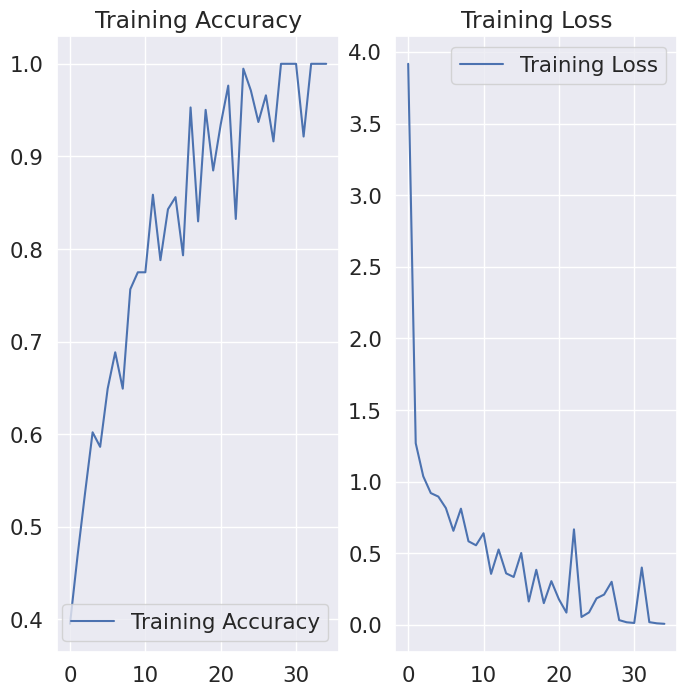

In [28]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [29]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = modelling.extract_labels_categorical(train_ds)

12/12 [==============================] - 16s 1s/step


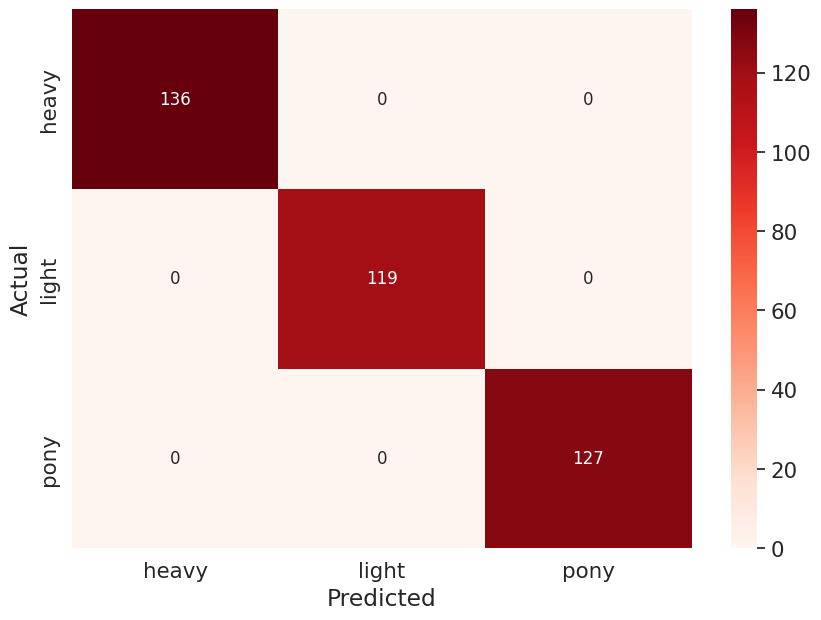

In [30]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
modelling.plot_cm(confusion_matrix_train, class_names)

In [31]:
print(classification_report(train_true_labels,train_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       127

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



In [32]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = modelling.extract_labels_categorical(val_ds)

3/3 [==============================] - 4s 1s/step


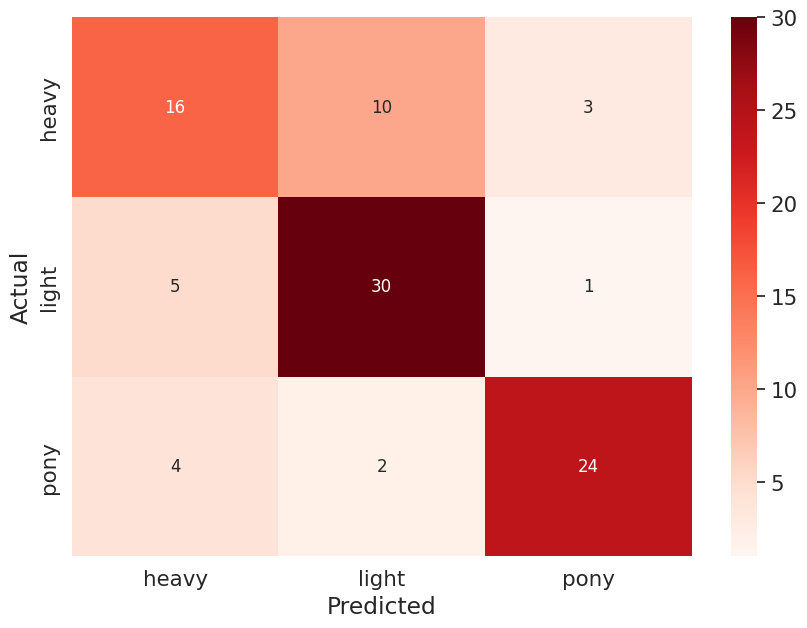

In [33]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
modelling.plot_cm(confusion_matrix_val, class_names)

In [34]:
print(classification_report(val_true_labels,val_predicted_labels))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59        29
           1       0.71      0.83      0.77        36
           2       0.86      0.80      0.83        30

    accuracy                           0.74        95
   macro avg       0.74      0.73      0.73        95
weighted avg       0.74      0.74      0.73        95



In [37]:
testset_predictions = model.predict(test_ds)
test_predicted_labels = [prediction.argmax() for prediction in testset_predictions]
test_true_labels = modelling.extract_labels_categorical(test_ds)

4/4 [==============================] - 17s 4s/step


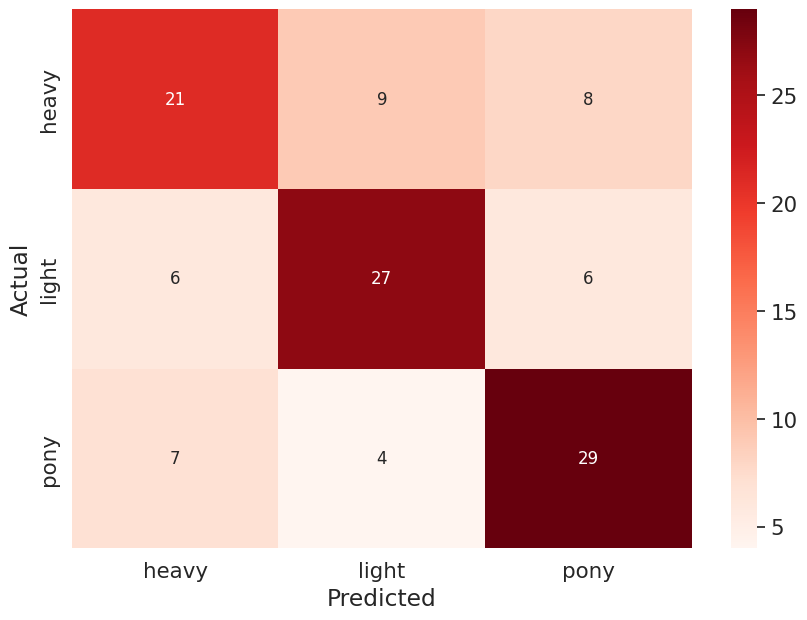

In [38]:
confusion_matrix_test = np.array(tf.math.confusion_matrix(test_true_labels, test_predicted_labels))
confusion_matrix_test = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
modelling.plot_cm(confusion_matrix_test, class_names)

In [39]:
print(classification_report(test_true_labels,test_predicted_labels))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58        38
           1       0.68      0.69      0.68        39
           2       0.67      0.72      0.70        40

    accuracy                           0.66       117
   macro avg       0.66      0.66      0.66       117
weighted avg       0.66      0.66      0.66       117



# Summary

- I trained the model for 35 epochs and it provided me with the perfect F1 scores for the training.
- The validation data performs suprisingly good as well
- The test data is also not too bad when kept in mind that nothing was done to regularize or improve the pipeline